# Tree models

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier

# Import data
from Preprocessing import X, Y, n_fold, cv, random_split 
trainX, trainY, testX, testY = random_split(0.8)

In [31]:
# K-fold cross validation function
def k_fold_cross_validation(MODEL, range_hyperparam:list, hyperparam_name:str, additional_params=None) -> np.array:
    """Performs k-fold cross validation for a given model and hyperparameter / range of hyperparameter"""
    acc = np.zeros(len(range_hyperparam))
    for train_index, val_index in cv.split(X): # Loopes over all folds
        X_train, X_val = X.iloc[train_index], X.iloc[val_index]
        Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

        for j,k in enumerate(range_hyperparam): # Loopes over all hyperparameters
            kwargs = {hyperparam_name: k}
            if additional_params is not None:
                kwargs.update(additional_params)
            model = MODEL(**kwargs)
            model.fit(X_train, Y_train)
            acc[j] += model.score(X_val, Y_val)

    acc /= n_fold # average of all average accuracies
    return acc

def best_hyperparam(acc, range_hyperparam, model, hyperparam_name, additional_params=None):
    """Returns the best hyperparameter based on the accuracy"""
    best_hyperparam = range_hyperparam[np.argmax(acc)]
    kwargs = {hyperparam_name: best_hyperparam}
    if additional_params is not None:
        kwargs.update(additional_params)
    BestModel = model(**kwargs)
    BestModel.fit(trainX, trainY)
    
    print('Accuracy with best hyperparameter: ', np.max(acc))
    print('Best hyperparameter: ', best_hyperparam, '\n')   
    print('Confusion matrix:')
    print(pd.crosstab(testY, BestModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False))
    pd.crosstab(testY, BestModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False)
        

### Classification Tree

1 tree different max depth:

In [ ]:
depths = range(1, 150)
acc_gini = k_fold_cross_validation(tree.DecisionTreeClassifier, depths, 'max_depth')
acc_entropy = k_fold_cross_validation(tree.DecisionTreeClassifier, depths, 'max_depth', {'criterion':'entropy'})


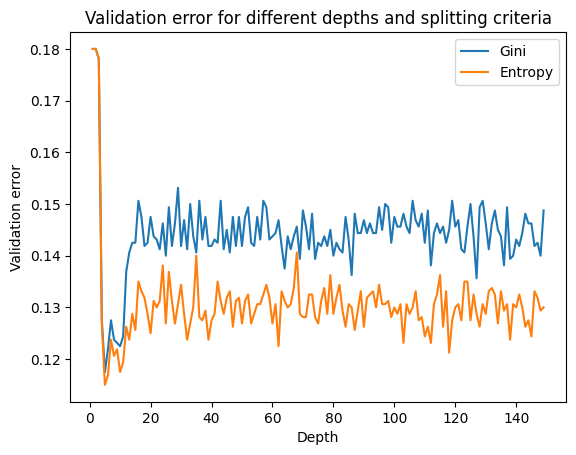

In [35]:
plt.plot(depths, 1- acc_gini, label='Gini')
plt.plot(depths, 1- acc_entropy, label='Entropy')
plt.xlabel('Depth')
plt.ylabel('Validation error')
plt.title('Validation error for different depths and splitting criteria')
plt.legend()
plt.savefig('Figures/SingleTree.png')
plt.show()

In [33]:
print(f'Best depth tree with Gini:\n')
best_hyperparam(acc_gini, depths, tree.DecisionTreeClassifier, 'max_depth')
print('\n\n')
print(f'Best depth tree with Entropy:\n')
best_hyperparam(acc_entropy, depths, tree.DecisionTreeClassifier, 'max_depth', {'criterion':'entropy'})

Best depth tree with Gini:

Accuracy with best hyperparameter:  0.8825
Best hyperparameter:  5 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                40               13
low_bike_demand                 18              249



Best depth tree with Entropy:

Accuracy with best hyperparameter:  0.885
Best hyperparameter:  5 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                40               13
low_bike_demand                 18              249


## Bagging

Test different number of trees:

In [6]:
trees = range(1, 150)
acc_bag = k_fold_cross_validation(BaggingClassifier, trees, 'n_estimators', {'n_jobs': -1})


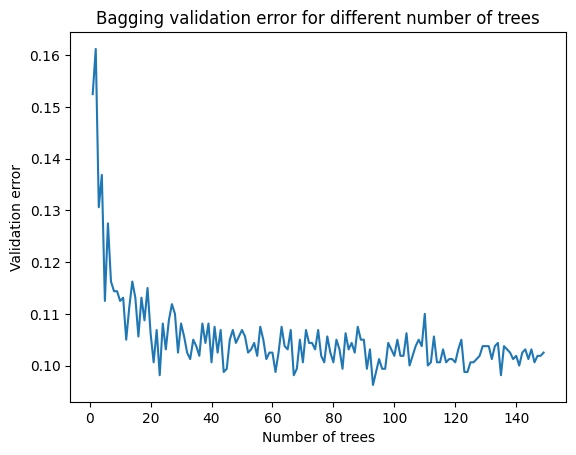

In [27]:
plt.plot(trees, 1 - acc_bag)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Bagging validation error for different number of trees')
plt.savefig('Figures/Bagging.png')
plt.show()

In [8]:
print('Best number of trees for bagging \n')
best_hyperparam(acc_bag, trees, BaggingClassifier, 'n_estimators')


Best number of trees for bagging 

Accuracy with best hyperparameter:  0.9037499999999999
Best hyperparameter:  93 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                37               16
low_bike_demand                 11              256


## Random Forest

Random forest with different number of trees

In [9]:
trees = range(1, 150)
acc_randf = k_fold_cross_validation(RandomForestClassifier, trees, 'n_estimators', {'random_state': 0, 'n_jobs': -1})

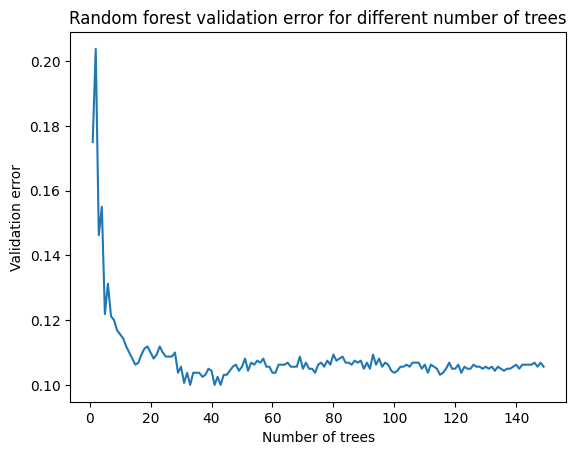

In [29]:
plt.plot(trees, 1 - acc_randf)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Random forest validation error for different number of trees')
plt.savefig('Figures/RandomForest.png')
plt.show()

In [11]:
print('Best number of trees for random forest \n')
best_hyperparam(acc_randf, trees, RandomForestClassifier, 'n_estimators')

Best number of trees for random forest 

Accuracy with best hyperparameter:  0.9000000000000001
Best hyperparameter:  41 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                32               21
low_bike_demand                  9              258


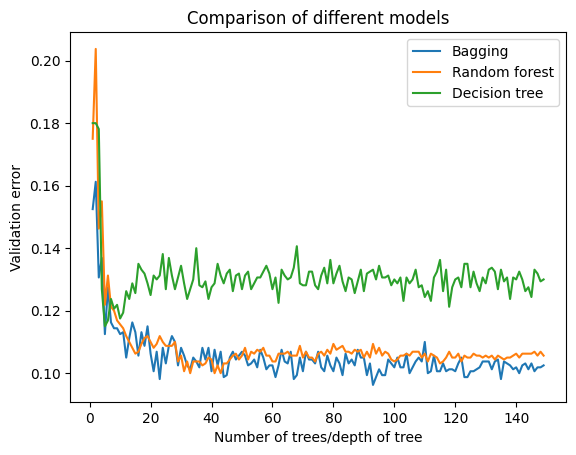

In [41]:
# Compare all models
plt.plot(trees, 1 - acc_bag, label='Bagging')
plt.plot(trees, 1 - acc_randf, label='Random forest')
plt.plot(depths, 1 - acc_entropy, label='Decision tree')

plt.xlabel('Number of trees/depth of tree')
plt.ylabel('Validation error')
plt.title('Comparison of different models')
plt.legend()
plt.savefig('Figures/AllTrees.png')
plt.show()

See that the bagging and random forest models perform equal. The decision tree seem to have optimal performance at if we use entropy split. Use this tree as the estimators for bagging and random forest:

In [52]:
trees2 = range(1, 150)
bestTree = tree.DecisionTreeClassifier(criterion='entropy')

acc_bag2 = k_fold_cross_validation(BaggingClassifier, trees2, 'n_estimators', {'estimator': bestTree, 'n_jobs': -1})
acc_randf2 = k_fold_cross_validation(RandomForestClassifier, trees2, 'n_estimators',{'criterion':'entropy', 'n_jobs': -1})


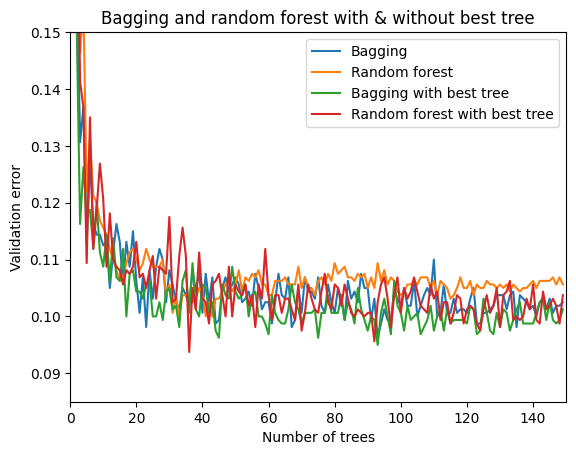

In [82]:
plt.plot(trees, 1 - acc_bag, label='Bagging')
plt.plot(trees, 1 - acc_randf, label='Random forest')
plt.plot(trees2, 1 - acc_bag2, label='Bagging with best tree')
plt.plot(trees2, 1 - acc_randf2, label='Random forest with best tree')

plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Bagging and random forest with & without best tree')
plt.xlim(0,150)
plt.ylim(0.085, 0.15)
plt.legend()
plt.savefig('Figures/BestTree.png')
plt.show()

In [74]:
print('Best number of trees for bagging with best tree \n')
best_hyperparam(acc_bag2, trees2, BaggingClassifier, 'n_estimators', {'estimator': bestTree})
print('\n-----------------------------------------------------\n')
print('Best number of trees for random forest with best tree \n')
best_hyperparam(acc_randf2, trees2, RandomForestClassifier, 'n_estimators' , {'criterion':'entropy'})

Best number of trees for bagging with best tree 

Accuracy with best hyperparameter:  0.905
Best hyperparameter:  93 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                38               15
low_bike_demand                 10              257

-----------------------------------------------------

Best number of trees for random forest with best tree 

Accuracy with best hyperparameter:  0.90625
Best hyperparameter:  36 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                34               19
low_bike_demand                  8              259


The best tree seems to improve results a tiny bit!

## Final model
Final best model is the Random forest classifier with entropy splitting and approximately 100 trees.

In [80]:
finalModel = RandomForestClassifier(n_estimators=100, criterion='entropy', n_jobs=-1, random_state=3)
finalModel.fit(trainX, trainY)
print('Accuracy of final model: ', finalModel.score(testX, testY))
print('Confusion matrix:')
pd.crosstab(testY, finalModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False)


finalModel = BaggingClassifier(n_estimators=100, estimator=bestTree, n_jobs=-1, random_state=3)
finalModel.fit(trainX, trainY)
print('Accuracy of final model: ', finalModel.score(testX, testY))
print('Confusion matrix:')
pd.crosstab(testY, finalModel.predict(testX), rownames=['True'], colnames=['Predicted'], margins=False)

Accuracy of final model:  0.9125
Confusion matrix:
Accuracy of final model:  0.925
Confusion matrix:


Predicted,high_bike_demand,low_bike_demand
True,,
high_bike_demand,39,14
low_bike_demand,10,257


## Disregarding some features in dataset
snow 0 all datapoints: should not be effect output


In [16]:
## Test with dropping irrelevant features
XnoSnow = X.drop(columns='snow')

trees3 = range(1, 150)
acc_noSnow_bag = np.zeros(len(trees3))
acc_noSnow_randf = np.zeros(len(trees3))

# K-fold cross validation
for train_index, val_index in cv.split(XnoSnow): # Loopar över alla folds
    X_train, X_val = XnoSnow.iloc[train_index], XnoSnow.iloc[val_index]
    Y_train, Y_val = Y.iloc[train_index], Y.iloc[val_index]

    for j,k in enumerate(trees3): # Classifier for each hyperparameter
        kwargs = {'n_estimators': k}
        Randf = RandomForestClassifier(**kwargs)
        Bag = BaggingClassifier(**kwargs)
        Randf.fit(X_train, Y_train)
        Bag.fit(X_train, Y_train)
        acc_noSnow_randf[j] += Randf.score(X_val, Y_val)
        acc_noSnow_bag[j] += Bag.score(X_val, Y_val)

acc_noSnow_randf /= n_fold # ta average av alla average accuracies
acc_noSnow_bag /= n_fold

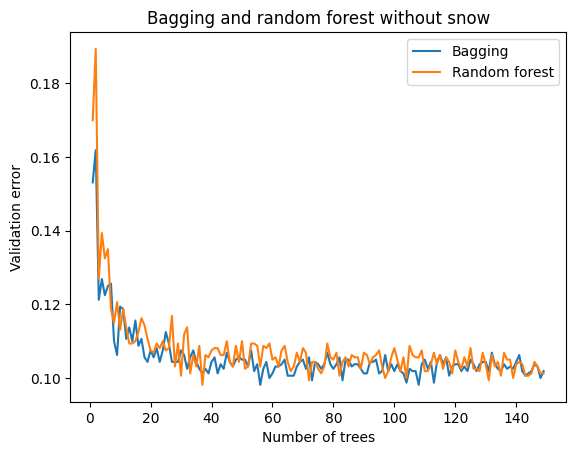

In [17]:
plt.plot(trees3, 1 - acc_noSnow_bag)
plt.plot(trees3, 1 - acc_noSnow_randf)
plt.xlabel('Number of trees')
plt.ylabel('Validation error')
plt.title('Bagging and random forest without snow')
plt.legend(['Bagging', 'Random forest'])
plt.show()

In [18]:
print('Best number of trees for bagging without snow \n')
best_hyperparam(acc_noSnow_bag, trees3, BaggingClassifier, 'n_estimators')
print('\n-----------------------------------------------------\n')
print('Best number of trees for random forest without snow \n')
best_hyperparam(acc_noSnow_randf, trees3, RandomForestClassifier, 'n_estimators')

Best number of trees for bagging without snow 

Accuracy with best hyperparameter:  0.9018750000000001
Best hyperparameter:  56 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                39               14
low_bike_demand                 11              256

-----------------------------------------------------

Best number of trees for random forest without snow 

Accuracy with best hyperparameter:  0.9018749999999999
Best hyperparameter:  37 

Confusion matrix:
Predicted         high_bike_demand  low_bike_demand
True                                               
high_bike_demand                31               22
low_bike_demand                  8              259
